# Exploratory Data Analysis

In [1]:
from glob import glob
import pandas as pd
import sqlite3
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

images = glob("./iNaturalist/images/Poison Ivy/*.j*")
labels = glob("./iNaturalist/images/Poison Ivy/*.txt")
labels.remove("./iNaturalist/images/Poison Ivy\\classes.txt")
n_images = len(images)
n_labeled = len(labels)
conn = sqlite3.connect("images.db")
c = conn.cursor()

n_objects = {}
record_ids = set()
max_record = 0
month_counts = {}
coords = []
min_record_id = 9999999

for f in labels:
    objects = sum(1 for line in open(f))
    n_objects[objects] = n_objects.get(objects, 0) + 1
    record_id = int(f.split("\\")[-1].split(".txt")[0])
    record_ids.add(record_id)
    if record_id > max_record:
        max_record = record_id

c.execute("SELECT * FROM images WHERE label LIKE 'Poison Ivy'")

for row in c.fetchall():
    if row[0] < min_record_id:
        min_record_id = row[0]
    if row[0] in record_ids:
        coords.append({"lat":row[4], "lon":row[5]})
        date = row[6]
        month = date.split("-")[1]
        month_counts[month] = month_counts.get(month, 0) + 1
        
n_images_reviewed = max_record - min_record_id

print(str(round(n_images_reviewed / n_images * 100, 1)) + "% of the images are reviewed ("+str(n_images_reviewed)+ " out of "+str(n_images) + " images)")

2.9% of the images are reviewed (353 out of 12037 images)


In [2]:
print(str(round(n_labeled / n_images * 100, 1)) + "% of the images are labeled ("+str(n_labeled)+ " out of "+str(n_images) + " images)")

1.9% of the images are labeled (231 out of 12037 images)


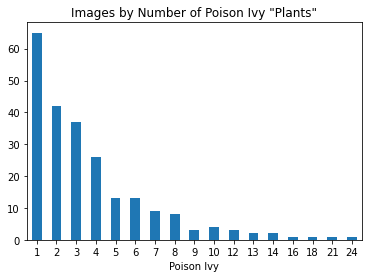

In [3]:
n_objects_df = pd.DataFrame.from_dict(n_objects, orient="index", columns=["Images"]).reset_index().sort_values("index").rename(columns={"index":"Poison Ivy"}).reset_index(drop=True)
n_objects_df.plot.bar(x="Poison Ivy", y="Images", rot=0, legend=False, title="Images by Number of Poison Ivy \"Plants\"");

In [4]:
display(HTML(n_objects_df.to_html(index=False)))

Poison Ivy,Images
1,65
2,42
3,37
4,26
5,13
6,13
7,9
8,8
9,3
10,4


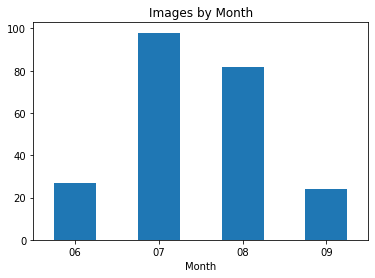

In [5]:
month_counts_df = pd.DataFrame.from_dict(month_counts, orient="index", columns=["Images"]).reset_index().sort_values("index").rename(columns={"index":"Month"}).reset_index(drop=True)
month_counts_df.plot.bar(x="Month", y="Images", rot=0, legend=False, title="Images by Month");

In [6]:
month_counts_df

,Month,Images
0,06,27
1,07,98
2,08,82
3,09,24


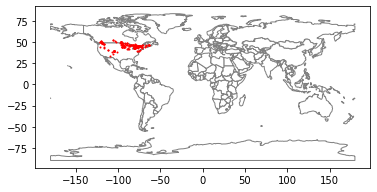

In [7]:
coords_df = pd.DataFrame(coords)
gdf = gpd.GeoDataFrame(coords_df, geometry=gpd.points_from_xy(coords_df.lon, coords_df.lat))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='gray')
gdf.plot(ax=ax, color='red', markersize=1)
plt.show()

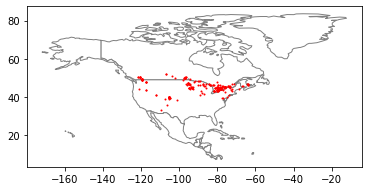

In [8]:
north_america = world[world.continent == "North America"].plot(color='white', edgecolor='gray')
gdf.plot(ax=north_america, color='red', markersize=1)
plt.show()